# Taxi demand prediction in New York City


<h1>1.Business/Real-world Problem</h1>

## 1.1 Problem statement

Predict the number of taxi pickups in a  given region in 10-min interval.

<h2>1.2. Real-world/Business objectives and constraints.</h2>

### 1.2.1. Objectives

<p>predict the number of pickups as accurately as possible for each region in a 10min interval.</p>

### 1.2.2. Constraints

* <b>Latency:</b> For given region and time interval,model should predict numbers of pickups in a few seconds.<br><br>

* <b>Interpretability:</b> As long as taxi driver gets good prediction result, he/she is not be much interested in the interpretability of the result. Hence, there is a no interpretability required.<br><br>

* <b>Relative Errors:</b> Mean Absolute Percentage Error. <br><br>

# 2. Data Information

<p>
Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

## Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credits: Quora</p>

<h5>Footnote:</h5>
In the given notebook we are considering only the yellow taxis for the time period of Jan 2015 and Jan 2016.

# 2.1. Data Collection
We Have collected all yellow taxi trips data of jan-2015 and jan-2016 (Will be using only 2015 data).
<table>
<tr>
<th> file name </th>
<th> file name size</th>
<th> number of records </th>
<th> number of features </th>
</tr>
<tr>
<td> yellow_tripdata_2016-01 </td>
<td> 1. 59G </td>
<td> 10906858 </td>
<td> 19 </td>
</tr>


<tr>
<td> yellow_tripdata_2015-01 </td>
<td> 1.84Gb </td>
<td> 12748986 </td>
<td> 19 </td>
</tr>

</table>

#### Importing Libraries

In [2]:
import dask.dataframe as dd
import pandas as pd
import folium 
import datetime 
import time 
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
tripdata_2015_01 = dd.read_csv('yellow_tripdata_2015-01.csv')
print(tripdata_2015_01.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


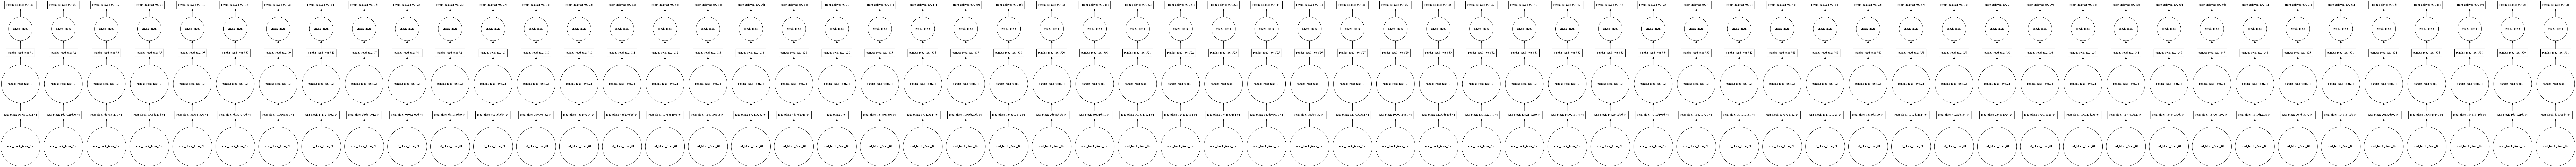

In [4]:
tripdata_2015_01.visualize()

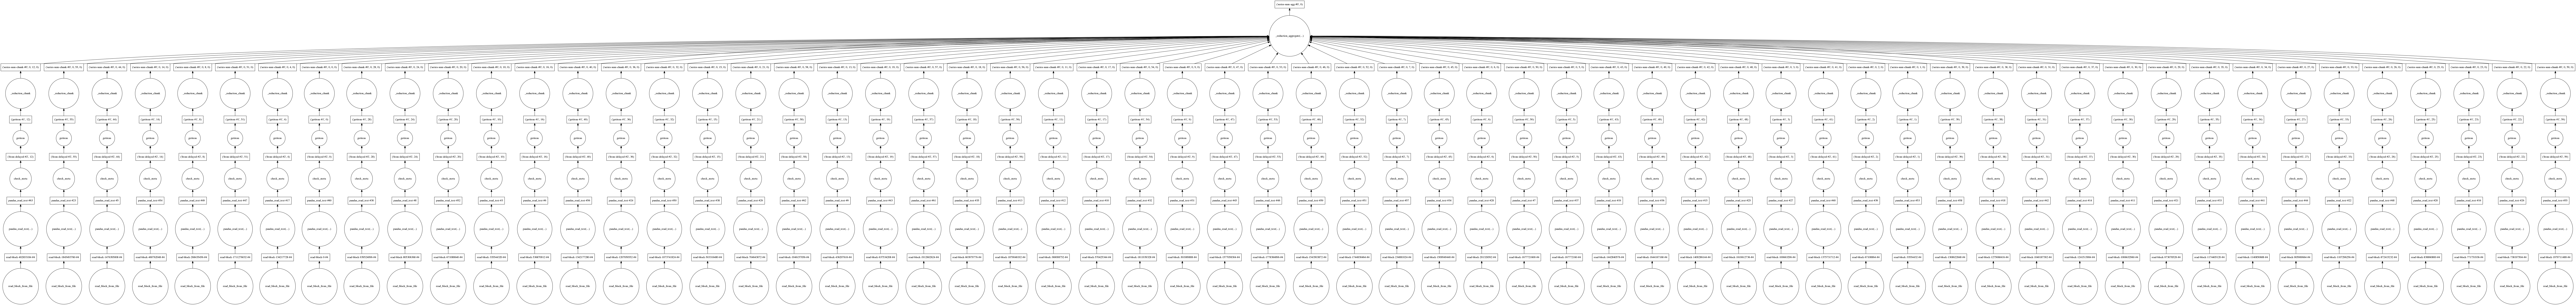

In [5]:
tripdata_2015_01.fare_amount.sum().visualize()

## 2.2.Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

## 3.ML Problem Formulation: Time Series Forecasting

Given a region and a 10min interval, we have to predict pickups.
* (a): How to break up the NYC into regions?
* (b): Every region of NYC has to be broken up into 10min  interval.<br>

Now, every row pickup has longitude and latitude in it, and we will use this to define pickup regions. 
We already know, about the pickup at time 't', we will predict the pickup at time 't+1' in the same region. Hence, this problem can be thought of as a 'Time Series Prediction' problem. It is a special case of regression problems. In short, we will use the data at time 't' to predict for time 't+1'.

# 3.1. Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

## 4. Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [6]:
#table below shows few datapoints along with all our features
tripdata_2015_01.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


### 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [7]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = tripdata_2015_01[((tripdata_2015_01.pickup_longitude <= -74.15) | (tripdata_2015_01.pickup_latitude <= 40.5774)| \
                   (tripdata_2015_01.pickup_longitude >= -73.7004) | (tripdata_2015_01.pickup_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.5774, -73.7004], tiles='Stamen Toner')

sample_locations = outlier_locations.head(25000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

### 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [8]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = tripdata_2015_01[((tripdata_2015_01.dropoff_longitude <= -74.15) | (tripdata_2015_01.dropoff_latitude <= 40.5774)| \
                   (tripdata_2015_01.dropoff_longitude >= -73.7004) | (tripdata_2015_01.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.5774, -73.7004], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(25000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude

### 3. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [9]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())


def return_with_trip_times(tripdata_2015_01):
    duration = tripdata_2015_01[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = tripdata_2015_01[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame
frame_with_durations = return_with_trip_times(tripdata_2015_01)

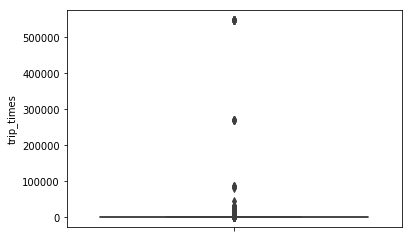

In [10]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [11]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [12]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is  548555.6333333333


<b>Observations</b>:Here, 0th percentile value of trip duration is negative(weird), also 99th percentile value of trip duration is 46.75min, but 100th percentile value is 548555.633min(weird). 0th and 100th percentile values are certainly an erroneous points.

In [13]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

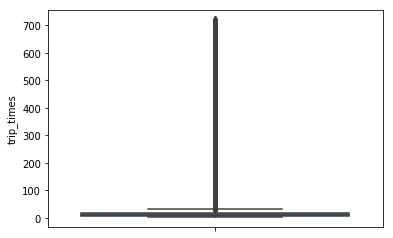

In [14]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show();

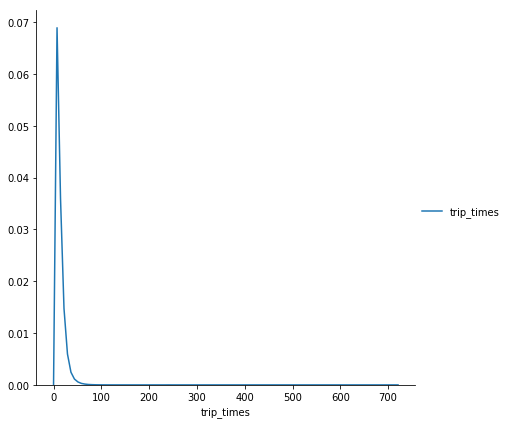

In [15]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [16]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

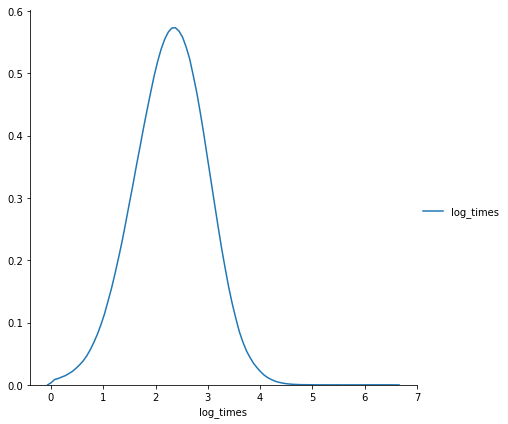

In [17]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

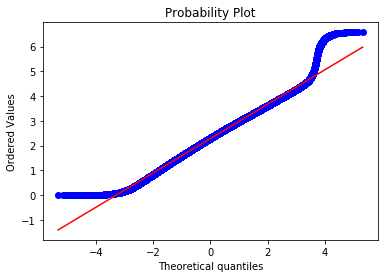

In [18]:
from scipy import stats
#Q-Q plot for checking if trip-times is log-normal
stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show();

### 4. Speed

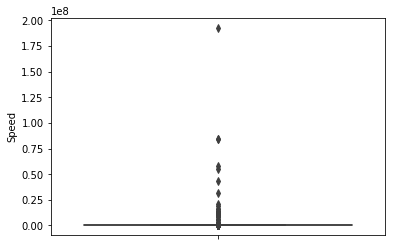

In [19]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [20]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [21]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [22]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


<b>Observations:</b> Here, 100th percentile value of a speed is 192 Million miles/hr which is strange. Furthermore, 99.9th percentile value of speed is 45.31miles/hr. So, we are removing all the data points where speed is greater than 45.31miles/hr.

In [23]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [24]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

<b style='font-size:16px'>The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

### 4. Trip Distance

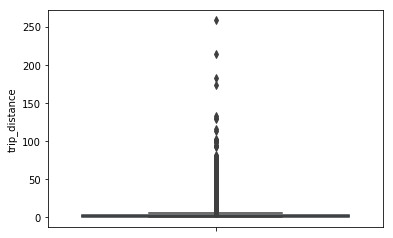

In [25]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [26]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [27]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [28]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


<b>Observation:</b> Here, 99.9th percentile of trip distance is 22.57miles, however, 100th percentile value is 258.9miles, which is very high. So, we are removing all the data points where trip distance is greater than 23miles.

In [29]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

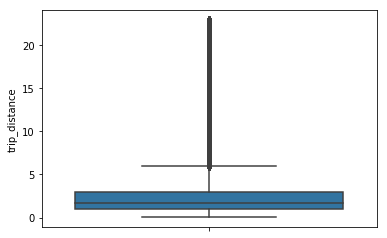

In [30]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 5. Total Fare

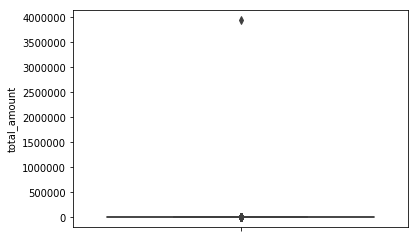

In [31]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [32]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [33]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [34]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


<b>Observation:-</b> As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

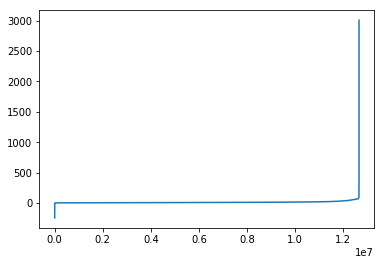

In [35]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

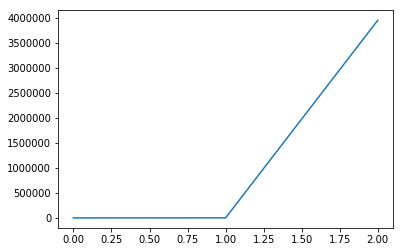

In [36]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

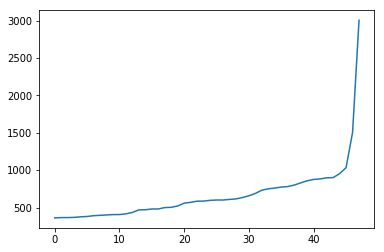

In [37]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers/erronous points.

In [38]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[(((new_frame.pickup_latitude >= 40.5774) &\
                     (new_frame.pickup_latitude <= 40.9176)) & \
                     ((new_frame.pickup_longitude >= -74.15) & \
                    (new_frame.pickup_longitude <= -73.7004)))]
    
    temp_frame = new_frame[(((new_frame.dropoff_latitude >= 40.5774) &\
                 (new_frame.dropoff_latitude <= 40.9176)) &\
                 ((new_frame.dropoff_longitude >= -74.15) & \
                 (new_frame.dropoff_longitude <= -73.7004)))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times>1) & (new_frame.trip_times<720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance>0) & (new_frame.trip_distance<23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed>0) & (new_frame.Speed<45.31)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount>0) & (new_frame.total_amount<86.6)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))    
    
    new_frame = new_frame[(new_frame.trip_times>1) & (new_frame.trip_times<720)]
    new_frame = new_frame[(new_frame.Speed>0) & (new_frame.Speed<45.31)]
    new_frame = new_frame[(new_frame.trip_distance>0) & (new_frame.trip_distance<23)]
    new_frame = new_frame[(new_frame.total_amount>0) & (new_frame.total_amount<86.6)]
    new_frame = new_frame[(((new_frame.pickup_latitude >= 40.5774) & (new_frame.pickup_latitude <= 40.9176)) & ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_longitude <= -73.7004)))]
    new_frame = new_frame[(((new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & ((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004)))]
    print("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [39]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 264440
Number of outliers from trip times analysis: 113740
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 101830
Number of outliers from fare analysis: 27561
Total outliers removed 407474
---
fraction of data points that remain after removing outliers 0.9680387130396095


# Data-preperation
## Clustering/Segmentation

In [40]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=100000 #1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) < 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0831433560720207 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.621480002405268 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.4474134603835399 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 10.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 30.0 
Min inter-cluster distance 

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 30

In [41]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [42]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.9176, -73.7004], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

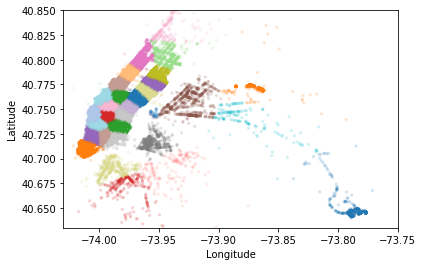

In [43]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning

In [44]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1451606400 : 2016-01-01 00:00:00 

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unixTime = [1420070400, 1451606400]
    start_pickup_unix=unixTime[year-2015]
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [45]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [46]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421349e+09,5.285319,20,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420922e+09,9.983193,13,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420922e+09,10.746269,18,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420922e+09,16.071429,4,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420922e+09,9.318378,0,1419


In [47]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              0                      123
               1                      280
               2                      360
               3                      367
               4                      384

In [48]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
tripdata_2016_01 = dd.read_csv('yellow_tripdata_2016-01.csv')


jan_2016_frame,jan_2016_groupby = datapreparation(tripdata_2016_01,kmeans,1,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 189129
Number of outliers from trip times analysis: 104609
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 84020
Number of outliers from fare analysis: 29544
Total outliers removed 324586
---
Estimating clusters..
Final groupbying..


## Smoothing

In [49]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [50]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

In [51]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(30):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  25
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  121
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  345
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  36
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  40
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  24
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  31
-----------

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [52]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [53]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [54]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [55]:
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  133920


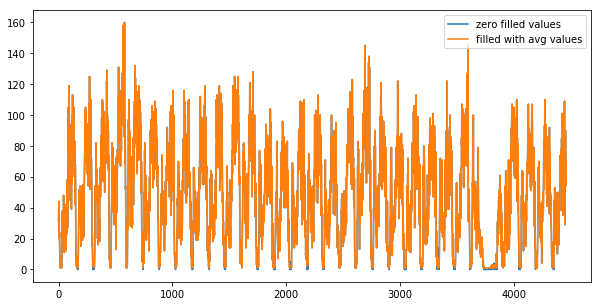

In [56]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [57]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

In [58]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)


regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464

for i in range(0,30):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)])



In [59]:
print(len(regions_cum))
print(len(regions_cum[0]))

30
4464


## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

In [60]:
ratios_jan = pd.DataFrame()
ratios_jan["Given"] = jan_2015_smooth
ratios_jan["Prediction"] = jan_2016_smooth
ratios_jan["Ratios"] = ratios_jan["Prediction"]*1.0/ratios_jan["Given"]*1.0

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [61]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [62]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [63]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [64]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*30):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [65]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [66]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*30):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [67]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [68]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.16260487350920483       MSE:  530.8284423536439
Moving Averages (2016 Values) -                        MAPE:  0.12674697834264703        MSE:  237.80671296296296
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.15990025582408013       MSE:  516.7837813620072
Weighted Moving Averages (2016 Values) -               MAPE:  0.12132508028521664       MSE:  225.14388440860216
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.15937324234342115       MSE:  510.8061753285544
Exponential Moving Averages (2016 Values) -         MAPE:  0.121255341

<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

## Regression Models

# Train-Test Split
Before we start predictions using the tree based regression models we take only one month of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [69]:
number_of_time_stamps = 5
output = []
tsne_lat = []
tsne_lon = []
tsne_weekday = []
tsne_feature = []
tsne_feature = [0]*number_of_time_stamps
for i in range(0,30):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*4459)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*4459)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [70]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 30*4459 == len(output)*len(output[0])

True

In [71]:
tsne_feature

array([[125, 286, 303, 319, 311],
       [286, 303, 319, 311, 327],
       [303, 319, 311, 327, 343],
       ...,
       [ 39,  37,  40,  52,  48],
       [ 37,  40,  52,  48,  41],
       [ 40,  52,  48,  41,  32]])

In [72]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,30):
    for i in range(0,4464):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [73]:
len(predict_list[0])*len(predict_list) == 4459*30

True

# FFT - taking top amplitudes and their corresponding freq as Features

In [74]:
amplitude_list = []
frequency_list = []
for i in range(30):
    amplitude  = np.abs(np.fft.fft(regions_cum[i][0:4096]))
    frequency = np.abs(np.fft.fftfreq(4096, 1))
    amplitude_indices = np.argsort(-amplitude)[1:]  
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):
        amplitude_values.append(amplitude[amplitude_indices[j]])
        frequency_values.append(frequency[amplitude_indices[j]])
    for k in range(4459):   
        amplitude_list.append(amplitude_values)
        frequency_list.append(frequency_values) 

# Regression Models - Data Preparation

In [75]:
print("Train Data Size :" +str(int(4459*0.8))) # 80% train data
print("Test Data Size:" +str(int(4459*0.2))) #20% test data

Train Data Size :3567
Test Data Size:891


In [76]:
train_previous_pickups  = [tsne_feature[i*4459:(4459*i+3567)] for i in range(30)]
test_previous_pickups  = [tsne_feature[(i*4459)+3567:(4459*(i+1))] for i in range(30)]
train_fourier_frq = [frequency_list[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_frq = [frequency_list[(i*4459)+3567:(4459*(i+1))] for i in range(30)]
train_fourier_amp = [amplitude_list[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_amp = [amplitude_list[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [77]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previous_pickups), len(train_previous_pickups[0]), len(train_previous_pickups)*len(train_previous_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previous_pickups), len(test_previous_pickups[0]), len(test_previous_pickups)*len(test_previous_pickups[0])))

Train Data: Total number of clusters = 30. Number of points in each cluster = 3567. Total number of training points = 107010
Test Data: Total number of clusters = 30. Number of points in each cluster = 892. Total number of test points = 26760


In [78]:
# extracting first 3567 timestamp values i.e 80% of 4459 (total timestamps) for our training data
tsne_train_flat_lat = [i[:3567] for i in tsne_lat]
tsne_train_flat_lon = [i[:3567] for i in tsne_lon]
tsne_train_flat_weekday = [i[:3567] for i in tsne_weekday]
tsne_train_flat_output = [i[:3567] for i in output]
tsne_train_flat_exp_avg = [i[:3567] for i in predict_list]

In [79]:
# extracting the rest of the timestamp values i.e 20% of 4459 (total timestamps) for our test data
tsne_test_flat_lat = [i[3567:] for i in tsne_lat]
tsne_test_flat_lon = [i[3567:] for i in tsne_lon]
tsne_test_flat_weekday = [i[3567:] for i in tsne_weekday]
tsne_test_flat_output = [i[3567:] for i in output]
tsne_test_flat_exp_avg = [i[3567:] for i in predict_list]

In [80]:
# convert from lists of lists of list to lists of list
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(30):
    train_pickups.extend(train_previous_pickups[i])
    test_pickups.extend(test_previous_pickups[i])
    train_freq.extend(train_fourier_frq[i])
    test_freq.extend(test_fourier_frq[i])
    train_amp.extend(train_fourier_amp[i])
    test_amp.extend(test_fourier_amp[i])

In [81]:
train_prevPickups_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_prevPickups_freq_amp = np.hstack((test_pickups, test_freq, test_amp))

In [82]:
print("Number of data points in train data = {}. Number of columns till now = {}".format(len(train_prevPickups_freq_amp), len(train_prevPickups_freq_amp[0])))
print("Number of data points in test data = {}. Number of columns till now = {}".format(len(test_prevPickups_freq_amp), len(test_prevPickups_freq_amp[0])))

Number of data points in train data = 107010. Number of columns till now = 15
Number of data points in test data = 26760. Number of columns till now = 15


In [83]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])


tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])


In [84]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'freq1', 'freq2','freq3','freq4','freq5', 'amp1', 'amp2', 'amp3', 'amp4', 'amp5']
df_train = pd.DataFrame(data=train_prevPickups_freq_amp, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(107010, 19)


In [85]:
df_train.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,amp1,amp2,amp3,amp4,amp5,lat,lon,weekday,exp_avg
0,125.0,286.0,303.0,319.0,311.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,4,310
1,286.0,303.0,319.0,311.0,327.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,4,321
2,303.0,319.0,311.0,327.0,343.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,4,336
3,319.0,311.0,327.0,343.0,332.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,4,333
4,311.0,327.0,343.0,332.0,321.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,4,324


In [86]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_prevPickups_freq_amp, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(26760, 19)


In [87]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,amp1,amp2,amp3,amp4,amp5,lat,lon,weekday,exp_avg
0,270.0,308.0,306.0,313.0,295.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,0,299
1,308.0,306.0,313.0,295.0,288.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,0,291
2,306.0,313.0,295.0,288.0,286.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,0,287
3,313.0,295.0,288.0,286.0,296.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,0,293
4,295.0,288.0,286.0,296.0,289.0,0.006836,0.00708,0.000977,0.013916,0.012939,183362.23631,141740.476375,100300.317756,90351.383443,68501.218978,40.761234,-73.968641,0,290


### Using Linear Regression

In [88]:
from sklearn.linear_model import LinearRegression
def linearRegression(x_tr, y_tr, x_test, y_test):
      #Data Standardization
    std = StandardScaler().fit(x_tr)
    x_tr = std.fit_transform(x_tr)
    x_test = std.fit_transform(x_test)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    alphaValues = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": alphaValues}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(x_tr, y_tr)
    alpha = best_parameter.best_params_["alpha"]
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(x_tr, y_tr)
    y_tr_pred = clf.predict(x_tr)
    train_MAPE = mean_absolute_error(y_tr, y_tr_pred)/ (sum(y_tr)/len(y_tr))
    train_MSE = mean_squared_error(y_tr, y_tr_pred)
    y_test_pred = clf.predict(x_test)
    test_MAPE = mean_absolute_error(y_test, y_test_pred)/ (sum(y_test)/len(y_test))
    test_MSE = mean_squared_error(y_test, y_test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

### Using Random Forest Regressor

In [89]:
def randomForestRegressor(x_tr, y_tr, x_test, y_test):
    
    #hyper parameter tuning
    n_est = [10, 40, 80, 150, 600, 800]
    clf = RandomForestRegressor(n_jobs = -1)
    hyper_parameter = {"n_estimators": n_est}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(x_tr, y_tr)
    optimal_est = best_parameter.best_params_["n_estimators"]
 
    
    #applying random forest regression with best hyper-parameter
    clf = RandomForestRegressor(n_estimators = optimal_est, n_jobs = -1)
    clf.fit(x_tr, y_tr)
    y_tr_pred = clf.predict(x_tr)
    train_MAPE = mean_absolute_error(y_tr, y_tr_pred)/ (sum(y_tr)/len(y_tr))
    train_MSE = mean_squared_error(y_tr, y_tr_pred)
    y_test_pred = clf.predict(x_test)
    test_MAPE = mean_absolute_error(y_test, y_test_pred)/ (sum(y_test)/len(y_test))
    test_MSE = mean_squared_error(y_test, y_test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

### Using XgBoost Regressor

In [90]:
def xgBoostRegressor(x_tr, y_tr, x_test, y_test):
    
    #hyper parameter tuning
    clf = xgb.XGBRegressor()
    hyper_parameter = {"max_depth":[1, 2, 3, 4,6,8,10], "n_estimators":[40, 80, 150,300, 600,1000]}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(x_tr, y_tr)
    optimal_est = best_parameter.best_params_["n_estimators"]
    optimal_depth = best_parameter.best_params_["max_depth"]
    
    #applying xgBoost regression with best hyper-parameter
    clf = xgb.XGBRegressor(max_depth = optimal_depth, n_estimators = optimal_est)
    clf.fit(x_tr, y_tr)
    y_tr_pred = clf.predict(x_tr)
    train_MAPE = mean_absolute_error(y_tr, y_tr_pred)/ (sum(y_tr)/len(y_tr))
    train_MSE = mean_squared_error(y_tr, y_tr_pred)
    y_test_pred = clf.predict(x_test)
    test_MAPE = mean_absolute_error(y_test, y_test_pred)/ (sum(y_test)/len(y_test))
    test_MSE = mean_squared_error(y_test, y_test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [91]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = linearRegression(df_train, tsne_train_output, df_test, tsne_test_output)
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf = randomForestRegressor(df_train, tsne_train_output, df_test, tsne_test_output)
trainMAPE_xgb, trainMSE_xgb, testMAPE_xgb, testMSE_xgb = xgBoostRegressor(df_train, tsne_train_output, df_test, tsne_test_output)

# Conclusion

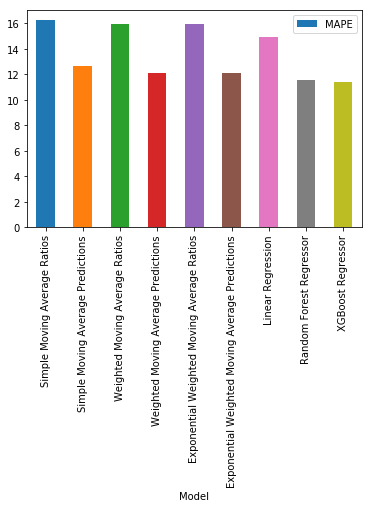

In [93]:
import matplotlib.pyplot as plt1
df = pd.DataFrame({
    'Model':['Simple Moving Average Ratios','Simple Moving Average Predictions','Weighted Moving Average Ratios','Weighted Moving Average Predictions','Exponential Weighted Moving Average Ratios','Exponential Weighted Moving Average Predictions','Linear Regression','Random Forest Regressor','XGBoost Regressor'],
    'MAPE':[mean_err[0]*100,mean_err[1]*100,mean_err[2]*100,mean_err[3]*100,mean_err[4]*100,mean_err[5]*100,testMAPE_lr*100,testMAPE_rf*100,testMAPE_xgb*100]
})

df.plot(kind='bar',x='Model',y='MAPE')
plt1.show()

In [99]:
from prettytable import PrettyTable 
t = PrettyTable() 
t.field_names = ['Model','MAPE'] 
t.add_row(["Moving Averages",mean_err[1]*100]) 
t.add_row(["Weighted Moving Averages",mean_err[3]*100]) 
t.add_row(["Exponential Moving Averages",mean_err[5]*100]) 
t.add_row(["linearRegression",testMAPE_lr*100]) 
t.add_row(["randomForestRegressor",testMAPE_rf*100]) 
t.add_row(["xgBoostRegressor",testMAPE_xgb*100]) 
print(t)
print("->Applied Discrete fourier transform using FFT,taken top five amplitudes and their corresponding frequencies as features.")
print("->xgBoostRegressor is best model as it is giving Mean Absolute percentage Error MAPE -11.41%.")

+-----------------------------+--------------------+
|            Model            |        MAPE        |
+-----------------------------+--------------------+
|       Moving Averages       | 12.674697834264704 |
|   Weighted Moving Averages  | 12.132508028521665 |
| Exponential Moving Averages | 12.125534100805575 |
|       linearRegression      | 14.943159062517813 |
|    randomForestRegressor    | 11.549949144414082 |
|       xgBoostRegressor      | 11.41146252018199  |
+-----------------------------+--------------------+
->Applied Discrete fourier transform using FFT,taken top five amplitudes and their corresponding frequencies as features.
->xgBoostRegressor is best model as it is giving Mean Absolute percentage Error MAPE -11.41%.
